In [ ]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam 
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random
import keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.makedirs('/content/spectrograms')
os.makedirs('/content/spectrograms/train')
os.makedirs('/content/spectrograms/test')

genres = 'blues classical country disco pop hiphop metal reggae rock'
genres = genres.split()
for g in genres:
  path_audio = os.path.join('/content/audio3sec',f'{g}')
  os.makedirs(path_audio)
  path_train = os.path.join('/content/drive/My Drive/spectrograms/train',f'{g}')
  path_test = os.path.join('/content/drive/My Drive/spectrograms/test',f'{g}')
  os.makedirs(path_train)
  os.makedirs(path_test)

In [ ]:
i = 0
for g in genres:
  j = 0
  print (f"{g}")
  for f in os.listdir(os.path.join('/content/drive/My Drive/genres_original',f"{g}")):
    song  =  os.path.join(f'/content/drive/My Drive/genres_original/{g}',f'{f}')
    j = j+1
    for k in range(0,10):
      i = i+1
      e1 = 3*(k)*1000
      e2 = 3*(k+1)*1000
      newAudio = AudioSegment.from_wav(song)
      new = newAudio[e1:e2]
      new.export(f'/content/audio3sec/{g}/{g+str(j)+str(k)}.wav', format="wav")

blues
classical
country
disco
pop
hiphop
metal
reggae
rock


blues
classical
country
disco
pop
hiphop
metal
reggae
rock


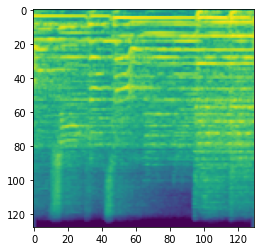

In [ ]:
for g in genres:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('/content/drive/MyDrive/genres_original',f"{g}")):
    song  =  os.path.join(f'/content/drive/MyDrive/genres_original/{g}',f'{filename}')
    j = j+1
    y,sr = librosa.load(song,duration=3)
    spect = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(spect,ref=np.max))
    plt.savefig(f'/content/drive/MyDrive/spectrograms/train/{g}/{g+str(j)}.png')

In [ ]:
path = "/content/drive/MyDrive/spectrograms/train/"
for g in genres:
  f = os.listdir(os.path.join(path,f"{g}"))
  random.shuffle(f)
  test = f[0:20]
  for a in test:
    shutil.move(path+f"{g}"+"/"+a,"/content/drive/MyDrive/spectrograms/test/"+f"{g}")

In [ ]:
train_dir = "/content/drive/MyDrive/spectrograms/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

validation_dir = "/content/drive/MyDrive/spectrograms/test/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)

Found 720 images belonging to 9 classes.
Found 180 images belonging to 9 classes.


In [ ]:
def GenreClassificationModel(input_shape = (288,432,4),classes=9):
  
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)
  
  X = Dropout(rate=0.3)(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreClassificationModel')

  return model

In [ ]:
def f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
  
model = GenreClassificationModel()
opt = Adam(learning_rate=0.0005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',f1]) 

model.fit_generator(train_generator,epochs=70,validation_data=vali_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/70
6/6 [==============================] - 527s 102s/step - loss: 4.4867 - accuracy: 0.1389 - f1: 0.1254 - val_loss: 2.2053 - val_accuracy: 0.1111 - val_f1: 0.0000e+00
Epoch 2/70
6/6 [==============================] - 84s 14s/step - loss: 2.8718 - accuracy: 0.1806 - f1: 0.1159 - val_loss: 2.2046 - val_accuracy: 0.1111 - val_f1: 0.0000e+00
Epoch 3/70
6/6 [==============================] - 81s 13s/step - loss: 2.4641 - accuracy: 0.2125 - f1: 0.1776 - val_loss: 2.2030 - val_accuracy: 0.1111 - val_f1: 0.0000e+00
Epoch 4/70
6/6 [==============================] - 80s 13s/step - loss: 2.0947 - accuracy: 0.2556 - f1: 0.1722 - val_loss: 2.2028 - val_accuracy: 0.1111 - val_f1: 0.0000e+00
Epoch 5/70
6/6 [==============================] - 84s 14s/step - loss: 1.9261 - accuracy: 0.3375 - f1: 0.2715 - val_loss: 2.2158 - val_accuracy: 0.1111 - val_f1: 0.0000e+00
Epoch 6/70
6/6 [==============================] - 84s 14s/step - loss: 1.7930 - accuracy: 0.3694 - f1: 0.2734 - val_loss: 2.2280 - va

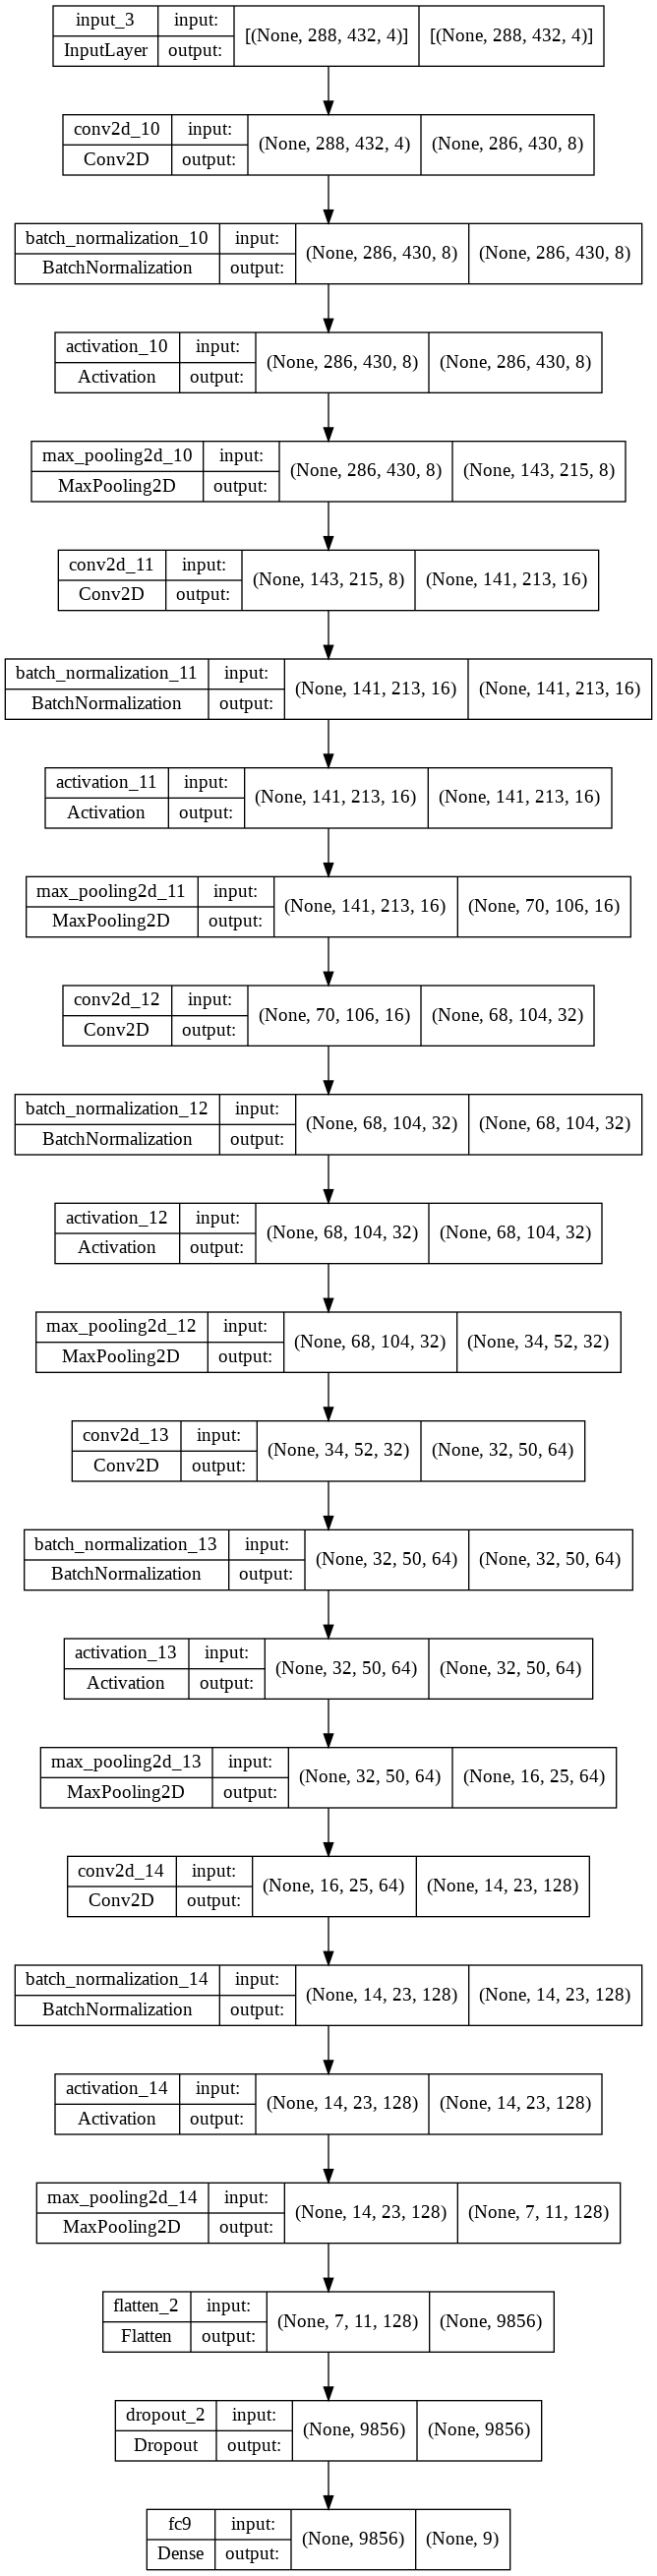

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model1 = GenreClassificationModel()
opt = Adam(learning_rate=0.005)
model1.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',f1]) 

history = model1.fit_generator(train_generator,epochs=5,validation_data=vali_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/5
6/6 [==============================] - 88s 15s/step - loss: 29.3080 - accuracy: 0.1111 - f1: 0.0973 - val_loss: 26.4394 - val_accuracy: 0.1111 - val_f1: 0.1238
Epoch 2/5
6/6 [==============================] - 85s 14s/step - loss: 18.1652 - accuracy: 0.1153 - f1: 0.1135 - val_loss: 54.0283 - val_accuracy: 0.1111 - val_f1: 0.1067
Epoch 3/5
6/6 [==============================] - 85s 14s/step - loss: 9.5795 - accuracy: 0.0861 - f1: 0.0867 - val_loss: 29.2819 - val_accuracy: 0.1111 - val_f1: 0.1010
Epoch 4/5
6/6 [==============================] - 85s 14s/step - loss: 6.3671 - accuracy: 0.1292 - f1: 0.0642 - val_loss: 6.9537 - val_accuracy: 0.1111 - val_f1: 0.1238
Epoch 5/5
6/6 [==============================] - 81s 13s/step - loss: 3.9192 - accuracy: 0.1167 - f1: 0.0646 - val_loss: 6.0621 - val_accuracy: 0.1111 - val_f1: 0.1095


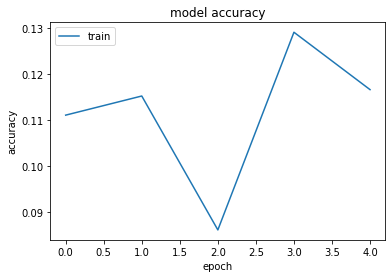

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()